In [2]:
# for pretty code
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

# Imports and functions

In [3]:
# imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import multiprocessing as mp

from tqdm import tqdm_notebook, tnrange, tqdm
from matplotlib.pyplot import figure
from newsrelations.query_db.relation_query import DBQueryHandlerCoocc
from newsrelations.helper_classes.synonym_handler import SynonymHandler
from newsrelations.metrics.distances import DistanceMeasure

<IPython.core.display.Javascript object>

In [4]:
def build_contingency_table_from_single_topic(
    relation_models_path, relation_models, topic_of_interest, no_entities=10
):
    """
    This function builds a contingency table from a input list of relation models generated with relation_miner.py 
    in regards to predetermined topic [TOPIC_OF_INTEREST].
    The first model in [RELATION_MODELS] is the reference model all other models will be compared with.
    The function extracts the top [NO_ENTITIES] co_occuring entities from the model and builds a contingency table.
    
    input:  relation_models = list
            relation_models_path = str 
            topic_of_interest = str           
            no_entities = int (standard 10)
            
    output: contingency_table = pandas DataFrame [rows = different models, columns = entities]
    """
    E1_SYNSET = 0
    E2_SYNSET = 1

    # initialize DistanceMeasure with reference-model
    dm = DistanceMeasure(relation_models_path, str(relation_models[0]))

    # extract top NO_ENTITIES entities
    top = dm.get_top_co_occurrences(
        topic_of_interest,
        cutoff=no_entities,
        e1_is_synset=E1_SYNSET,
        e2_is_synset=E2_SYNSET,
    )
    # write first row of contingency_table
    contingency_table = pd.DataFrame(
        np.array([t[1] for t in top]),
        index=[t[0] for t in top],
        columns=[str(relation_models[0])],
    )

    # loop through all remaining models
    for model in relation_models[1:]:
        # initialize db_handler()
        db_handler = DBQueryHandlerCoocc(relation_models_path, model)

        # buffer for cooccurrences
        co_occs = []
        # loop through all entities and get number of co-occurrences
        for row in contingency_table.index:
            co_occs.append(
                len(
                    list(
                        db_handler.select_relations(
                            e1=topic_of_interest.lower(),
                            e2=row.lower(),
                            e1_is_synset=E1_SYNSET,
                            e2_is_synset=E2_SYNSET,
                        )
                    )
                )
            )

        contingency_table[str(model)] = co_occs

    # transpose the contingency table to get it into the right format
    contingency_table = contingency_table.transpose()
    return contingency_table

<IPython.core.display.Javascript object>

In [5]:
def explain_models(relation_models):
    """
    This function lists the models from the relation_models list and their counter index
    
    Input: relation_models = list
    
    Output: None
    """
    i = 0
    for model in relation_models:
        print("model(" + str(i) + "): " + str(model))
        i += 1
    return

<IPython.core.display.Javascript object>

In [6]:
def build_contingency_table_from_topic_list(
    relation_models_path, relation_models, topic_of_interest_list, no_entities=10
):
    """
    This function builds a contingency table from a input list of relation models generated with relation_miner.py 
    in regards to predetermined topic list [topic_of_interest_list].
    The first model in [relation_models] is the reference model all other models will be compared with.
    The function extracts the top [no_entities] co-occuring entities for the first [topic_of_interest] from the 
    model and builds a contingency table.
    
    
    input:  relation_models = list
            relation_models_path = str 
            topic_of_interest_list = list           
            no_entities = int (standard 10)
            
    output: contingency_table = pandas DataFrame [rows = different models, columns = entities]
    """
    # identifier for models in relation_models_list
    i = 0
    # print models with idx
    explain_models(relation_models)

    # initialize DistanceMeasure with reference-model
    dm = DistanceMeasure(relation_models_path, str(relation_models[0]))

    # extract top NO_ENTITIES entities
    top = dm.get_top_co_occurrences(
        topic_of_interest_list[0], cutoff=no_entities, e1_is_synset=0, e2_is_synset=0
    )
    # write first row of contingency_table
    contingency_table = pd.DataFrame(
        np.array([t[1] for t in top]),
        index=[t[0] for t in top],
        columns=[str(topic_of_interest_list[0]) + " (" + str(i) + ")"],
    )

    # loop through the models
    for model in relation_models[:]:
        # initialize db_handler()
        db_handler = DBQueryHandlerCoocc(relation_models_path, model)

        for topic in topic_of_interest_list:
            # buffer for co-occurrencces
            co_occs = []

            # loop through all all entities and get number of co-occurrences
            for row in contingency_table.index:
                co_occs.append(
                    len(
                        list(
                            db_handler.select_relations(
                                e1=topic.lower(),
                                e2=row.lower(),
                                e1_is_synset=0,
                                e2_is_synset=0,
                            )
                        )
                    )
                )
            contingency_table[str(topic) + " (" + str(i) + ")"] = co_occs

        i += 1

    # transpose the contingency table to get it into the right format
    contingency_table = contingency_table.transpose()

    return contingency_table

<IPython.core.display.Javascript object>

In [7]:
def compare_entity_lists(
    relation_models_path, relation_models, topic_list1, topic_list2
):
    """
    This function creates a contingency table from a two input lists of entities [topic_list1][topic_list2]
    from a list of relation models 
    
    input:  relation_models = list
            relation_models_path = str 
            topic_list1 = list           
            topic_list2 = list
            
    output: contingency_table = pandas DataFrame [rows = different models, columns = entities]
    """
    # idx for models
    i = 0

    # print models with idx
    explain_models(relation_models)

    # initialize contingency_table
    contingency_table = pd.DataFrame(index=topic_list2)

    # loop through the models
    for model in relation_models:
        # initialize db_handler()
        db_handler = DBQueryHandlerCoocc(relation_models_path, model)

        for topic1 in topic_list1:
            # buffer for co-occurrencces
            co_occs = []

            # loop through all all entities and get number of co-occurrences
            for topic2 in topic_list2:
                co_occs.append(
                    len(
                        list(
                            db_handler.select_relations(
                                e1=topic1.lower(),
                                e2=topic2.lower(),
                                e1_is_synset=0,
                                e2_is_synset=0,
                            )
                        )
                    )
                )
            contingency_table[str(topic1) + " (" + str(i) + ")"] = co_occs

        i += 1

    # transpose the contingency table to get it into the right format
    contingency_table = contingency_table.transpose()

    return contingency_table

<IPython.core.display.Javascript object>

In [8]:
def chi_squared(contingency_table, print_orig = False, print_expect = False, print_chi_contr = False):
    """
    This function conducts a chi-squared test of independence between the different rows of a contingency table
    
    input: contingency_table
    
    ouput: None
    """
    contingency_table = sm.stats.Table(contingency_table)
    results = contingency_table.test_nominal_association()
    
    
    # orig contingency table
    if print_orig == True:
        print("Original contingency table:")
        print(contingency_table.table_orig)
    # expected values
    if print_expect == True:
        print("\nExpected values:")
        print(contingency_table.fittedvalues)
    # chi-squared contributions
    if print_chi_contr == True:
        print("\nChi-square contributions:")
        print(contingency_table.chi2_contribs)
    
    # results
    print("\nResults:")
    print(results)

   
    return


<IPython.core.display.Javascript object>

In [9]:
def do_chi_squared_comparison(
    relation_models_path, relation_models, topic_of_interest, no_entities
):
    """
    This function extracts chi-squared test results for all combinations of news-outlets
    
    input: contingency_table
    
    ouput: None
    """

    # extracting a contingency table from a single reference entity
    i = 0
    j = 0

    df_results = pd.DataFrame()

    for i in range(len(relation_models)):
        for j in range(len(relation_models)):
            models = []
            models = [relation_models[i]] + [relation_models[j]]

            contingency_table = build_contingency_table_from_single_topic(
                relation_models_path, models, topic_of_interest, no_entities
            )

            contingency_table = sm.stats.Table(contingency_table)
            results = contingency_table.test_nominal_association()

            df_results[
                str(relation_models[i][-10:-7])
                + " - "
                + str(relation_models[j][-10:-7])
            ] = [
                results.statistic,
                results.pvalue,
            ]

    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: "chi_sq", 1: "p_value"})
    df_results

    return df_results

<IPython.core.display.Javascript object>

In [10]:
import smtplib, ssl
from getpass import getpass

smtp_server = "smtp.gmail.com"
port = 587  # For starttls
sender_email = "pythonserver.jonas.m.ehrhardt@gmail.com"
password = getpass()

# Create a secure SSL context
context = ssl.create_default_context()


def message_me(calculation_ID):
    """
    This function sends me an email, when called, with the calculation ID given in input ;) 
    """
    # Try to log in to server and send email
    try:
        server = smtplib.SMTP(smtp_server, port)
        server.ehlo()  # Can be omitted
        server.starttls(context=context)  # Secure the connection
        server.ehlo()  # Can be omitted
        server.login(sender_email, password)

        sender = "pythonserver.jonas.m.ehrhardt@gmail.com"
        receivers = ["jonas@xorentec.de"]

        message = (
            "From: Jonas Pythonserver\nSubject: Calculation finished\nThe Calculation "
            + calculation_ID
            + " is finished..."
        )

        server.sendmail(sender, receivers, message)

        print("Successfully sent email")

    except Exception as e:
        print(e)
    finally:
        server.quit()

    return

········


<IPython.core.display.Javascript object>

In [11]:
message_me("test")

Successfully sent email


<IPython.core.display.Javascript object>

# Datasets

Variable setups for different runs of models (all scraped from commoncrawl.com)

In [ ]:
# First Try
# general tryout on the NewsRelations Library

# directory path of relation models
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/firstTry"

# model name
RELATION_MODELS = [
    "model.sqlite",
]

In [ ]:
# Second Try
# models from newssources with different biases 
#
# -year:    2008 (for foxnews 2o08-2010)
# -domain:  politics
# -sources: NYT & foxnews 

# directory path of relation models 
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/secondTry"

# model nameslf, path_or_b
RELATION_MODELS = [
    "RMadvanced_2008_politics_nytimes.sqlite",
    "RM_2009_politics_nytimes.sqlite",
    "RM_2008-2010_politics_foxnews.sqlite",
]



In [ ]:
# Third Try
# models from newssources with different biases 
#
# -year:    2011
# -domain:  news
# -sources: reuters & national public radio

# directory path of relation models 
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/thirdTry"

# model names
RELATION_MODELS = [
    "RM_2011_news_reuters.sqlite",
    "RM_2011_news_npr.sqlite",
]



In [ ]:
# Fourth try
# two models from newssources with different biases each, for comparing slant coherence within
# different directions. Timeslots with gapless news reporting were chosen.
#
# -year:    2011-01-01 - 2011-03-31
# -domain:  news
# -sources(left):    New York Times (NYT) 637, Washington Post (WP) 508
#         (center):  National Public Radio (NPR) 109, Reuters (RET) 300
#         (right):   FoxNews (FN) 2735, Newsmax (NM) 180

# directory path of relation models
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/fourthTry"

# model names
RELATION_MODELS = [
    "RM_2011_news_NYT.sqlite",
    "RM_2011_news_WPO.sqlite",
    "RM_2011_news_NPR.sqlite",
    "RM_2011_news_RET.sqlite",
    "RM_2011_news_FXN.sqlite",
    "RM_2011_news_NMX.sqlite",
]


# Final datasets

Final datasets used in the paper

In [13]:
# Dataset for parameter estimation
# for the estiation of parameters number of entities and topic_of_interest
#
# -year:    2012
# -domain:  news
# -sources(left):    Huffington Post (HFP) 4909, New York Times (NYT) 2541,
#         (center):  CNN (CNN) 2491, Reuters (RET) 2135
#         (right):   FoxNews (FXN) 3784, (WSJ) 1215

# directory path of relation models
RELATION_MODELS_PATH = (
    "/home/jonas/Documents/GitHub/MasterThesis/models/calibrationDataset"
)

# model names
RELATION_MODELS = [
    "RM_2012_news_HFP.sqlite",
    "RM_2012_news_NYT.sqlite",
    "RM_2012_news_CNN.sqlite",
    "RM_2012_news_RET.sqlite",
    "RM_2012_news_FXN.sqlite",
    "RM_2012_news_WSJ.sqlite",
]

<IPython.core.display.Javascript object>

In [14]:
# Final Dataset
# final daset based on works of Budak (2016) Flaxmann (2016) and Groseclose (2015)
#
# -year:    2011
# -domain:  news
# -sources(left):    Huffington Post (HFP) 14876, LA Times (LAT) 445, New York Times (NYT) 11281,
#                    Washington Post (WP) 14814, Daily KOS (DKO) 123
#         (center):  BBC (BBC) 52, CNN (CNN) 2652, Reuters (RET) 16767, Yahoo News (YHN) 211
#         (right):   Chicago Tribune (CTB) 2843, FoxNews (FXN) 6508, NBC (NBC) 3958, USA Today (UST) 171
#                    Wall Street Journal (WSJ) 2522, Breitbart (BBT) 76

# directory path of relation models
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/finalDataset"

# model names
RELATION_MODELS = [
    "RM_2011_news_BBC.sqlite",
    "RM_2011_news_BBT.sqlite",
    "RM_2011_news_CNN.sqlite",
    "RM_2011_news_CTB.sqlite",
    "RM_2011_news_DKO.sqlite",
    "RM_2011_news_FXN.sqlite",
    "RM_2011_news_HFP.sqlite",
    "RM_2011_news_LAT.sqlite",
    "RM_2011_news_NBC.sqlite",
    "RM_2011_news_NYT.sqlite",
    "RM_2011_news_RET.sqlite",
    "RM_2011_news_UST.sqlite",
    "RM_2011_news_WPO.sqlite",
    "RM_2011_news_WSJ.sqlite",
    "RM_2011_news_YHN.sqlite",
]


<IPython.core.display.Javascript object>

# Parameter estimation

## Estimation of "n" - number of entities 

To estimate the optimal n, I examine the stability of the p-value during chi-square tests with different n's, within same slant and between different slant groups


In [10]:
# hyper-parameters
# directory path of relation models
RELATION_MODELS_PATH = (
    "/home/jonas/Documents/GitHub/MasterThesis/models/calibrationDataset"
)

# model names
RELATION_MODELS = [
    "RM_2012_news_HFP.sqlite",
    "RM_2012_news_NYT.sqlite",
    "RM_2012_news_CNN.sqlite",
    "RM_2012_news_RET.sqlite",
    "RM_2012_news_FXN.sqlite",
    "RM_2012_news_WSJ.sqlite",
]

# path to results folder
RESULTS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/results/"

# max number of entities + 1, to compare with the reference entity
NO_ENTITIES = 31

# reference entity -
TOPIC_OF_INTEREST = "obama"

<IPython.core.display.Javascript object>

In [10]:
# estimate optimal n - within same slant groups
models = [
    [RELATION_MODELS[0], RELATION_MODELS[1]],
    [RELATION_MODELS[1], RELATION_MODELS[0]],
    [RELATION_MODELS[2], RELATION_MODELS[3]],
    [RELATION_MODELS[3], RELATION_MODELS[2]],
    [RELATION_MODELS[4], RELATION_MODELS[5]],
    [RELATION_MODELS[5], RELATION_MODELS[4]],
]

# initialize dataframes and counter for columns
df = pd.DataFrame()

# loop through model constellation in models list
def loopy_poopy(models):
    df_results = pd.DataFrame()
    description = str(str(models[0][-10:-7]) + "-" + str(models[1][-10:-7]))
    # loop through entity numbers until max entity is reached
    for n in tnrange(1, NO_ENTITIES, desc=description):
        # create SQL query and build contingency table for sm.stats
        contingency_table = build_contingency_table_from_single_topic(
            RELATION_MODELS_PATH, models, TOPIC_OF_INTEREST, n
        )
        contingency_table = sm.stats.Table(contingency_table)
        # calculate results + add them to dataframe
        results = contingency_table.test_nominal_association()
        df_results[n] = [results.pvalue]

    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: description})
    
    return df_results

# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df = pd.concat(pool.map(loopy_poopy, [model for model in models]), axis=1)

# close loop
pool.close()



# save results to csv
df.to_csv(
    "/home/jonas/Documents/GitHub/MasterThesis/results/nSameSlant_All_"+ TOPIC_OF_INTEREST +".csv", index=False
)

message_me("nSameSlant_All")

/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


<IPython.core.display.Javascript object>

In [11]:
df = pd.read_csv(
    "/home/jonas/Documents/GitHub/MasterThesis/results/nSameSlant_All_"
    + TOPIC_OF_INTEREST
    + ".csv"
)
df

,HFP-NYT,NYT-HFP,CNN-RET,RET-CNN,FXN-WSJ,WSJ-FXN
0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.098532e-02,6.207193e-03,9.076773e-03,9.076773e-03,7.093043e-02,7.093043e-02
2,1.879725e-05,4.333479e-03,6.193064e-03,6.193064e-03,9.818179e-04,1.805599e-01
3,1.411185e-06,5.134556e-03,6.710873e-03,6.710873e-03,3.238803e-03,2.958139e-01
4,4.577465e-07,7.299786e-03,8.506702e-03,8.506702e-03,8.186405e-03,4.202882e-01
5,2.978889e-07,1.091177e-02,1.160689e-02,1.160689e-02,1.753743e-02,5.432615e-01
6,8.458100e-07,1.424716e-02,5.093868e-05,1.380572e-02,3.322518e-02,6.567830e-01
7,2.202647e-06,1.905356e-02,9.229880e-05,1.708460e-02,5.122393e-02,7.528592e-01
8,1.890103e-06,1.291363e-02,1.636657e-04,1.421303e-09,7.566331e-02,5.282848e-02
9,9.103158e-07,7.031063e-04,1.018670e-10,2.900569e-12,1.644216e-02,7.511453e-03


<IPython.core.display.Javascript object>

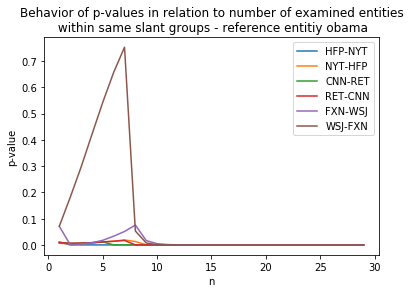

<Figure size 1440x720 with 0 Axes>

<IPython.core.display.Javascript object>

In [12]:
# Visualze

df.plot(kind="line")

plt.ylabel("p-value")
plt.xlabel("n")
plt.title(
    "Behavior of p-values in relation to number of examined entities\n within same slant groups - reference entitiy "
    + TOPIC_OF_INTEREST
)
plt.legend()
plt.figure(figsize=(20, 10))
plt.show()

In [11]:
# estimate optimal n - within different slant groups
models = [
    [RELATION_MODELS[0], RELATION_MODELS[2]],
    [RELATION_MODELS[0], RELATION_MODELS[3]],
    [RELATION_MODELS[0], RELATION_MODELS[4]],
    [RELATION_MODELS[0], RELATION_MODELS[5]],
    [RELATION_MODELS[1], RELATION_MODELS[2]],
    [RELATION_MODELS[1], RELATION_MODELS[3]],
    [RELATION_MODELS[1], RELATION_MODELS[4]],
    [RELATION_MODELS[1], RELATION_MODELS[5]],
    [RELATION_MODELS[2], RELATION_MODELS[0]],
    [RELATION_MODELS[2], RELATION_MODELS[1]],
    [RELATION_MODELS[2], RELATION_MODELS[4]],
    [RELATION_MODELS[2], RELATION_MODELS[5]],
    [RELATION_MODELS[3], RELATION_MODELS[0]],
    [RELATION_MODELS[3], RELATION_MODELS[1]],
    [RELATION_MODELS[3], RELATION_MODELS[4]],
    [RELATION_MODELS[3], RELATION_MODELS[5]],
    [RELATION_MODELS[4], RELATION_MODELS[0]],
    [RELATION_MODELS[4], RELATION_MODELS[1]],
    [RELATION_MODELS[4], RELATION_MODELS[2]],
    [RELATION_MODELS[4], RELATION_MODELS[3]],
    [RELATION_MODELS[5], RELATION_MODELS[0]],
    [RELATION_MODELS[5], RELATION_MODELS[1]],
    [RELATION_MODELS[5], RELATION_MODELS[2]],
    [RELATION_MODELS[5], RELATION_MODELS[3]],
]

# initialize dataframes and counter for column name
df = pd.DataFrame()


def looping_louie(models):
    # loop through model constellation in models list
    # for constellation in tqdm(models):
    df_results = pd.DataFrame()
    description = str(str(models[0][-10:-7]) + "-" + str(models[1][-10:-7]))
    # loop through entity numbers until max entity is reached
    for n in tnrange(1, NO_ENTITIES, desc=description):

        # create SQL query and build contingency table for sm.stats
        contingency_table = build_contingency_table_from_single_topic(
            RELATION_MODELS_PATH, models, TOPIC_OF_INTEREST, n
        )
        contingency_table = sm.stats.Table(contingency_table)
        # calculate results + add them to dataframe
        results = contingency_table.test_nominal_association()
        df_results[n] = [results.pvalue]

    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: description})

    return df_results


# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df = pd.concat(pool.map(looping_louie, [model for model in models]), axis=1)

# close loop
pool.close()

# save results to csv
df.to_csv(
    "/home/jonas/Documents/GitHub/MasterThesis/results/nDiffSlant_All"
    + TOPIC_OF_INTEREST
    + ".csv",
    index=False,
)

message_me("nDiffSlant_All")

/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
/home/jonas/anaconda3/lib/python3.7/site









Successfully sent email


<IPython.core.display.Javascript object>

In [12]:
df = pd.read_csv("/home/jonas/Documents/GitHub/MasterThesis/results/nDiffSlant_All"+ TOPIC_OF_INTEREST +".csv")
df

,HFP-CNN,HFP-RET,HFP-FXN,HFP-WSJ,NYT-CNN,NYT-RET,NYT-FXN,NYT-WSJ,CNN-HFP,CNN-NYT,...,RET-FXN,RET-WSJ,FXN-HFP,FXN-NYT,FXN-CNN,FXN-RET,WSJ-HFP,WSJ-NYT,WSJ-CNN,WSJ-RET
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.460466,0.112523,0.246958,0.302348,3.195005e-04,3.636778e-05,2.923972e-05,5.614149e-02,4.604660e-01,3.538596e-02,...,1.284218e-03,0.934684,0.246958,6.171758e-02,0.665953,1.284218e-03,3.023483e-01,4.759865e-03,1.237877e-01,0.934684
2,0.716445,0.038993,0.416326,0.464304,9.180223e-05,4.650041e-06,4.392315e-06,5.318312e-02,7.164453e-01,2.430109e-06,...,1.422612e-03,0.868171,0.097032,7.758095e-03,0.572549,1.349568e-09,4.643042e-01,8.679671e-05,2.653281e-01,0.868171
3,0.866497,0.032232,0.587100,0.569461,7.377851e-05,2.367241e-06,2.614091e-06,6.563935e-02,8.664972e-01,4.999711e-08,...,1.873583e-03,0.954063,0.121982,9.249358e-07,0.702103,5.528071e-09,5.694614e-01,9.289419e-06,3.907475e-01,0.954063
4,0.942418,0.034279,0.726566,0.671075,8.899760e-05,2.180216e-06,2.723252e-06,8.794144e-02,9.424180e-01,8.008650e-09,...,2.718487e-03,0.985174,0.170732,1.056081e-08,0.815182,1.930140e-08,6.710753e-01,2.878371e-06,5.159523e-01,0.985174
5,0.977029,0.041004,0.829907,0.760473,2.377125e-04,1.076437e-07,4.050984e-06,1.553601e-02,9.770287e-01,3.394567e-09,...,4.114997e-03,0.995548,0.232495,8.911215e-10,0.892307,6.016166e-08,7.604728e-01,1.597800e-06,6.320539e-01,0.995548
6,0.988123,0.036852,0.903458,0.850616,4.893172e-04,3.165682e-07,8.971503e-06,1.720835e-02,8.998929e-01,1.063586e-08,...,3.876902e-03,0.949887,0.305238,2.182643e-10,0.940797,1.713074e-07,8.506155e-01,4.738963e-06,7.258674e-01,0.949887
7,0.994225,0.036766,0.948185,0.911608,9.494337e-04,8.516781e-07,1.897488e-05,2.074050e-02,9.319270e-01,3.193379e-08,...,4.050016e-03,0.915997,0.394414,6.921524e-10,0.971753,3.154163e-07,9.116082e-01,1.261097e-05,8.035963e-01,0.915997
8,0.955634,0.010804,0.486022,0.510208,4.420341e-04,8.954112e-07,1.035258e-06,4.621617e-03,9.556340e-01,8.839082e-08,...,3.885781e-15,0.099185,0.486022,2.031978e-09,0.987244,5.816521e-07,4.014589e-03,8.790175e-06,8.897994e-04,0.519454
9,0.977046,0.018657,0.495840,0.338974,1.426294e-07,4.273067e-08,3.852474e-14,3.986669e-03,3.823637e-02,8.398504e-11,...,0.000000e+00,0.110241,0.248597,5.561570e-09,0.508463,3.547946e-08,6.386108e-03,8.606403e-06,5.737152e-04,0.609871


<IPython.core.display.Javascript object>

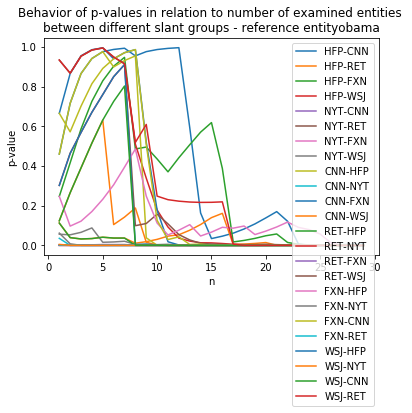

<Figure size 1440x720 with 0 Axes>

<IPython.core.display.Javascript object>

In [13]:
# Visualze

df.plot(kind="line")

plt.xlabel("n")
plt.ylabel("p-value")
plt.title(
    "Behavior of p-values in relation to number of examined entities \nbetween different slant groups - reference entity"
    + TOPIC_OF_INTEREST
)
plt.legend()
plt.figure(figsize=(20, 10))
plt.show()

## Estimation of optimal number of "topic_of_interest"

To estimate the optimal number of different reference-entities, I examine the behavior of the p-value witin and between different slant groups, under varying reference entities. The entities are derived from Gentzkow (2010) and XXXX (XXXX) and represent controverse topics and non-controvers topics

In [ ]:
# hyper-parameters
# directory path of relation models
RELATION_MODELS_PATH = (
    "/home/jonas/Documents/GitHub/MasterThesis/models/calibrationDataset"
)

# model names
RELATION_MODELS = [
    "RM_2012_news_HFP.sqlite",
    "RM_2012_news_NYT.sqlite",
    "RM_2012_news_CNN.sqlite",
    "RM_2012_news_RET.sqlite",
    "RM_2012_news_FXN.sqlite",
    "RM_2012_news_WSJ.sqlite",
]

# path to results folder
RESULTS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/results/"

# number of entities to compare with the reference entitiy
NO_ENTITIES = 16

# reference entities
TOPIC_OF_INTEREST_LIST = [
    "sport",
    "obama",
    "bush",
    "united_states",
    "healthcare",
    "insurance",
    "gun",
    "school",
    "death_tax",
    "terrorism",
    "Al_Kaida",
    "Germany",
    "France",
    "health_care",
]

In [ ]:
# initialize dataframes and counter for column name
df = pd.DataFrame()
# NPR and NMX (center - conservative)
models = [RELATION_MODELS[0], RELATION_MODELS[4]]


def estimate_topic_differences(topic):
    # loop through model constellation in models list
    # for constellation in tqdm(models):
    df_results = pd.DataFrame()
    description = str(str(models[0][-10:-7]) + "-" + str(models[1][-10:-7]))
    # loop through entity numbers until max entity is reached
    for n in tnrange(1, NO_ENTITIES, desc=topic):
        try:
            # create SQL query and build contingency table for sm.stats
            contingency_table = build_contingency_table_from_single_topic(
                RELATION_MODELS_PATH, models, topic, n
            )
            contingency_table = sm.stats.Table(contingency_table)
            # calculate results + add them to dataframe
            results = contingency_table.test_nominal_association()
            df_results[n] = [results.pvalue]
        except:
            print("There is too little data for " + topic)
            break

    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: topic})

    return df_results


# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df = pd.concat(
    pool.map(estimate_topic_differences, [topic for topic in TOPIC_OF_INTEREST_LIST]),
    axis=1,
)

# close pool
pool.close()

# save results to csv
df.to_csv(
    "/home/jonas/Documents/GitHub/MasterThesis/results/diffTopic_diffNP.csv", index=False
)

message_me("diffTopic_diffNP")


In [ ]:
df = pd.read_csv(
    "/home/jonas/Documents/GitHub/MasterThesis/results/diffTopic_diffNP.csv"
)
df

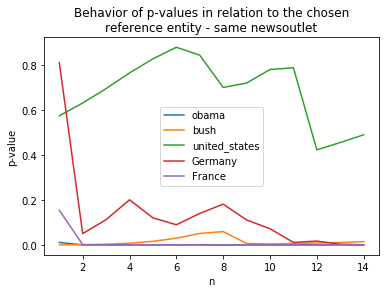

<Figure size 1440x720 with 0 Axes>

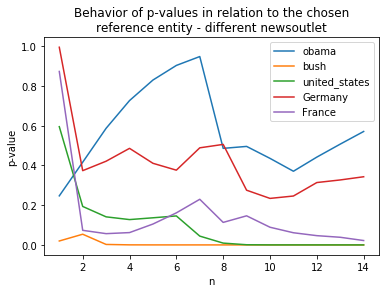

<Figure size 1440x720 with 0 Axes>

<IPython.core.display.Javascript object>

In [14]:
# Visualze
df = pd.read_csv("/home/jonas/Documents/GitHub/MasterThesis/results/diffTopic.csv")
df.plot(kind="line")

plt.xlabel("n")
plt.ylabel("p-value")
plt.title(
    "Behavior of p-values in relation to the chosen\nreference entity - same newsoutlet"
)
plt.figure(figsize=(20, 10))
plt.show()

df = pd.read_csv(
    "/home/jonas/Documents/GitHub/MasterThesis/results/diffTopic_diffNP.csv"
)
df.plot(kind="line")

plt.xlabel("n")
plt.ylabel("p-value")
plt.title(
    "Behavior of p-values in relation to the chosen\nreference entity - different newsoutlet"
)
plt.figure(figsize=(20, 10))
plt.show()

# Hypothesis testing 

## Hypothesis 1

1.1 Within same slant groups the co-occurring entities are independent from the
    news-outlet

1.2 Between different slant groups the co-occurring entities are dependent from
    the news-outlet

In [12]:
# directory path of relation models
RELATION_MODELS_PATH = "/home/jonas/Documents/GitHub/MasterThesis/models/finalDataset"

# model names
RELATION_MODELS = [
    "RM_2011_news_CNN.sqlite",
    "RM_2011_news_CTB.sqlite",
    "RM_2011_news_FXN.sqlite",
    "RM_2011_news_HFP.sqlite",
    "RM_2011_news_NBC.sqlite",
    "RM_2011_news_NYT.sqlite",
    "RM_2011_news_RET.sqlite",
    "RM_2011_news_WPO.sqlite",
    "RM_2011_news_WSJ.sqlite",
]

"""
"RM_2011_news_BBC.sqlite",
"RM_2011_news_LAT.sqlite",
"RM_2011_news_UST.sqlite",
"RM_2011_news_YHN.sqlite",
"RM_2011_news_BBT.sqlite",
"RM_2011_news_DKO.sqlite",
"""


TOPIC_OF_INTEREST = "obama"

NO_ENTITIES = 11

<IPython.core.display.Javascript object>

In [51]:
# compare everything with everything
models = []

# set up list of model combinations
for i in RELATION_MODELS:
    for j in RELATION_MODELS:
        if i == j:
            continue
        else:
            models.append([i, j])

# initialize dataframes and counter for column name
df = pd.DataFrame()

def hello_kitty_action_plan(models):
    # loop through model constellation in models list
    df_results = pd.DataFrame()
    description = str(str(models[0][-10:-7]) + "-" + str(models[1][-10:-7]))
    try:
        # create SQL query and build contingency table for sm.stats
        contingency_table = build_contingency_table_from_single_topic(
            RELATION_MODELS_PATH, models, TOPIC_OF_INTEREST, NO_ENTITIES
        )
        contingency_table = sm.stats.Table(contingency_table)
        # calculate results + add them to dataframe
        results = contingency_table.test_nominal_association()
        df_results[description] = [str(models[0][-10:-7]), str(models[1][-10:-7]), description, results.statistic, results.pvalue]
    except:
        print("There is too little data for " + TOPIC_OF_INTEREST)

    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0: "reference", 1:"comparison", 2: "combination", 3: str("chi_sq"), 4: str("p_value")})

    return df_results


# Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# concat the pool-parallelized dataframes from pathlist
df = pd.concat(pool.map(hello_kitty_action_plan, [model for model in models]), axis=0)

# close pool 
pool.close()

# save results to csv
df.to_csv(
    "/home/jonas/Documents/GitHub/MasterThesis/results/hyp1"
    + TOPIC_OF_INTEREST
    + ".csv",
    index=False,
)

message_me("hyp1")


Successfully sent email


<IPython.core.display.Javascript object>

In [61]:
df = pd.read_csv(
    "/home/jonas/Documents/GitHub/MasterThesis/results/hyp1"
    + TOPIC_OF_INTEREST
    + ".csv"
)
pd.set_option("display.max_rows", None)
df

,combination,chi_sq,p_value
0,CNN-CTB,18.318458,4.982350e-02
1,CNN-FXN,13.324069,2.061129e-01
2,CNN-HFP,29.909157,8.864434e-04
3,CNN-NBC,11.624835,3.109491e-01
4,CNN-NYT,165.568671,0.000000e+00
5,CNN-RET,87.790681,1.465494e-14
6,CNN-WPO,48.463728,5.106446e-07
7,CNN-WSJ,27.735015,1.990199e-03
8,CTB-CNN,22.043345,1.488530e-02
9,CTB-FXN,48.133217,5.868559e-07


<IPython.core.display.Javascript object>

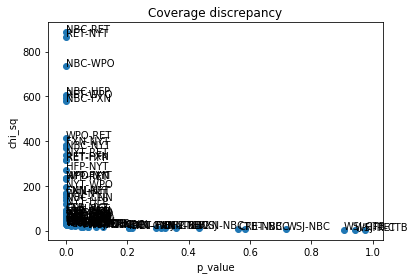

<Figure size 14400x12800 with 0 Axes>

<IPython.core.display.Javascript object>

In [127]:
fig, ax = plt.subplots()
ax.scatter(df.p_value, df.chi_sq)

for i, txt in enumerate(df.combination):
    ax.annotate(txt, (df.p_value[i], df.chi_sq[i]))

plt.xlabel("p_value")
plt.ylabel("chi_sq")
plt.title("Coverage discrepancy")
fig = plt.figure(figsize=(180, 160), dpi=80, facecolor="w", edgecolor="k")
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

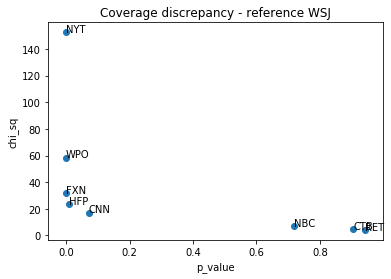

<IPython.core.display.Javascript object>

In [143]:
# split df into list and reset indices
df_list = [df.loc[i : i + 8 - 1, :] for i in range(0, len(df), 8)]
for df_single in df_list:
    df_single = df_single.reset_index(drop=True, inplace=True)


for i in range(len(df_list)):
    # fig, ax = plt.subplots()
    plt.subplot(len(df_list), 1, i + 1)
    ax = plt.subplot()
    plt.scatter(df_list[i].p_value, df_list[i].chi_sq)

    for j, txt in enumerate(df_list[i].combination):
        ax.annotate(txt[-3:], (df_list[i].p_value[j], df_list[i].chi_sq[j]))

    plt.xlabel("p_value")
    plt.ylabel("chi_sq")
    plt.title("Coverage discrepancy - reference " + str(df_list[i].combination[0][:3]))

plt.show

KeyError: 0

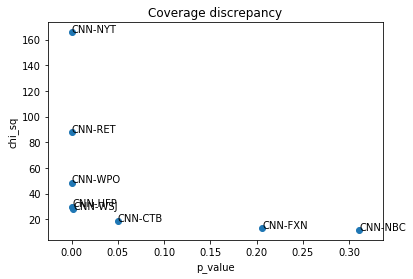

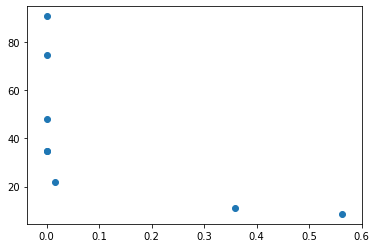

<IPython.core.display.Javascript object>

In [132]:
# split df into list
df_list = [df.loc[i : i + 8 - 1, :] for i in range(0, len(df), 8)]
df_list[1]

for df_single in df_list:
    fig, ax = plt.subplots()
    ax.scatter(df_single.p_value, df_single.chi_sq)

    for i, txt in enumerate(df_cnn.combination):
        ax.annotate(txt, (df_single.p_value[i], df_single.chi_sq[i]))
    plt.xlabel("p_value")
    plt.ylabel("chi_sq")
    plt.title("Coverage discrepancy")

plt.show()

In [53]:
# Visualze

df.plot(kind="scatter")

plt.xlabel("n")
plt.ylabel("p-value")
plt.title(
    "Behavior of p-values in relation to number of examined entities \nbetween different slant groups"
)
plt.legend()
plt.figure(figsize=(20, 10))
plt.show()

ValueError: scatter requires an x and y column

<IPython.core.display.Javascript object>

## Hypothesis 2

It is possible to cluster same slant news-outlets via their co-occurrences into same slant groups 

## Hypothesis 3

A combination of residual analysis, sentiment analysis and co-occurrences can help to identify slant 